--- 1. LOADING DATA ---
   -> Đang tính toán vị trí (Layout)...
   -> Dữ liệu sẵn sàng: 2434 đỉnh.
--- 2. ĐANG PHÂN CỤM... ---
   -> Progress: 0/2434
   -> Progress: 1000/2434
   -> Progress: 2000/2434

--- 3. ĐANG VẼ BẢN ĐỒ TINH GỌN (LỌC CỤM NHỎ & NHIỄU) ---
   -> Tìm thấy 12 cụm thô.
   -> Giữ lại 12 cụm lớn (Size >= 15) để vẽ.


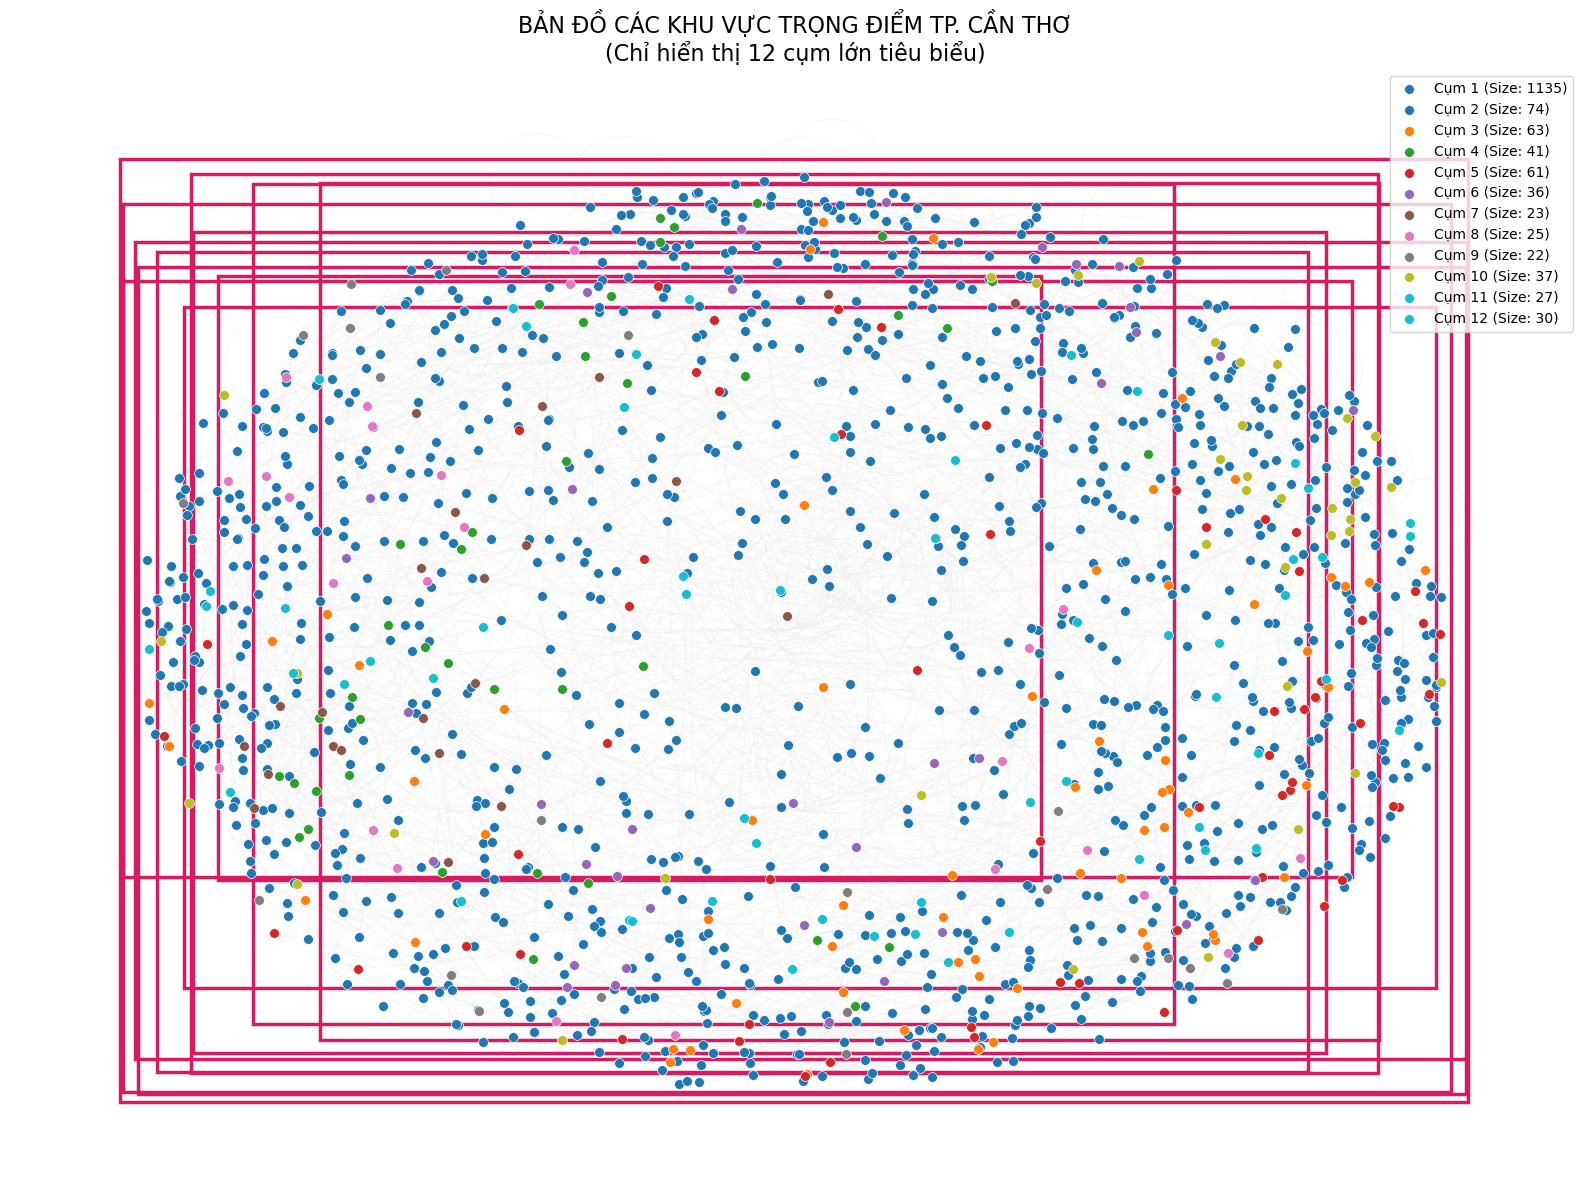

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import heapq
import numpy as np
from io import StringIO
from collections import Counter

# ==============================================================================
# 1. NẠP DỮ LIỆU
# ==============================================================================
FILE_PATH = r'D:\GIS_Project\data\6_DSCanhKQ2_CanTho_XoaCon3Cot_XoaDongTrung.txt'

print(f"--- 1. LOADING DATA ---")
try:
    df = pd.read_csv(FILE_PATH, sep='\t')
    df.columns = df.columns.str.strip()
    if 'IdStar' in df.columns: df.rename(columns={'IdStar': 'IdStart'}, inplace=True)
    
    G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')
    for u, v in G.edges(): G[u][v]['weight'] = G[u][v]['Length']
    
    # --- TỐI ƯU LAYOUT (QUAN TRỌNG) ---
    print("   -> Đang tính toán vị trí (Layout)...")
    # k=0.5: Đẩy các điểm ra xa hơn nữa để tránh chồng chéo
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=100) 
    
    all_points = list(G.nodes())
    print(f"   -> Dữ liệu sẵn sàng: {len(all_points)} đỉnh.")

except Exception as e:
    print(f"[ERROR] {e}")
    # Dữ liệu mẫu nếu lỗi
    G = nx.grid_2d_graph(20, 20); pos = nx.spring_layout(G)
    all_points = list(G.nodes())

# ==============================================================================
# 2. CHẠY THUẬT TOÁN (LOGIC CŨ)
# ==============================================================================
def get_network_neighbors(G, start_node, eps):
    distances = {start_node: 0}
    queue = [(0, start_node)]
    nbrs = []
    while queue:
        d, u = heapq.heappop(queue)
        if d > eps: continue
        nbrs.append(u)
        for v in G.neighbors(u):
            new_d = d + G[u][v]['weight']
            if new_d <= eps and new_d < distances.get(v, float('inf')):
                distances[v] = new_d
                heapq.heappush(queue, (new_d, v))
    return nbrs

def run_clustering(G, points, eps, min_pts):
    print("--- 2. ĐANG PHÂN CỤM... ---")
    neighbors_cache = {}
    for i, p in enumerate(points):
        if i % 1000 == 0: print(f"   -> Progress: {i}/{len(points)}")
        neighbors_cache[p] = get_network_neighbors(G, p, eps)
        
    ordered_points = sorted(points, key=lambda x: len(neighbors_cache[x]), reverse=True)
    
    labels = {}
    cluster_id = 0
    NOISE = -1
    
    for p in ordered_points:
        if p in labels: continue
        if len(neighbors_cache[p]) < min_pts:
            labels[p] = NOISE
        else:
            cluster_id += 1
            labels[p] = cluster_id
            seeds = list(neighbors_cache[p])
            while seeds:
                q = seeds.pop(0)
                if q in labels:
                    if labels[q] == NOISE: labels[q] = cluster_id
                else:
                    labels[q] = cluster_id
                    if len(neighbors_cache[q]) >= min_pts: seeds.extend(neighbors_cache[q])
    return labels

# ==============================================================================
# 3. HÀM VẼ TINH GỌN (CLEAN VISUALIZATION)
# ==============================================================================
def visualize_clean_clusters(G, labels, pos, min_cluster_size=10):
    """
    min_cluster_size: Chỉ vẽ các cụm có số lượng điểm >= con số này.
    """
    print("\n--- 3. ĐANG VẼ BẢN ĐỒ TINH GỌN (LỌC CỤM NHỎ & NHIỄU) ---")
    
    # 1. Lọc các cụm đủ lớn
    # Đếm số lượng điểm trong mỗi cụm (trừ Noise -1)
    cluster_counts = Counter([l for l in labels.values() if l != -1])
    
    # Chỉ giữ lại các ID cụm lớn
    major_clusters = [cid for cid, count in cluster_counts.items() if count >= min_cluster_size]
    
    if not major_clusters:
        print(f"Cảnh báo: Không có cụm nào lớn hơn {min_cluster_size} điểm. Hãy giảm min_cluster_size hoặc tăng Eps.")
        return

    print(f"   -> Tìm thấy {len(cluster_counts)} cụm thô.")
    print(f"   -> Giữ lại {len(major_clusters)} cụm lớn (Size >= {min_cluster_size}) để vẽ.")

    plt.figure(figsize=(16, 12))
    ax = plt.gca()
    
    # 2. Vẽ nền: Chỉ vẽ các CẠNH nối giữa các điểm thuộc cụm lớn (để hình đỡ rối)
    # Hoặc vẽ mờ toàn bộ mạng lưới nếu muốn giữ ngữ cảnh
    # Ở đây ta vẽ mờ toàn bộ cho đẹp
    nx.draw_networkx_edges(G, pos, edge_color='#EEEEEE', width=0.8, alpha=0.4)
    
    # 3. Vẽ Các Cụm Lớn
    # Bảng màu
    colors = plt.cm.tab10(np.linspace(0, 1, len(major_clusters)))
    
    for i, cid in enumerate(major_clusters):
        cluster_nodes = [n for n, l in labels.items() if l == cid]
        color = colors[i % len(colors)]
        
        # A. Vẽ điểm (Node)
        nx.draw_networkx_nodes(G, pos, nodelist=cluster_nodes, 
                               node_color=[color], node_size=50, 
                               edgecolors='white', linewidths=0.5,
                               label=f'Cụm {cid} (Size: {len(cluster_nodes)})')
        
        # B. Vẽ Khung (Bounding Box)
        xs = [pos[n][0] for n in cluster_nodes]
        ys = [pos[n][1] for n in cluster_nodes]
        
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)
        
        padding = 0.08 # Tăng padding để khung thoáng hơn
        width = max_x - min_x + padding
        height = max_y - min_y + padding
        origin = (min_x - padding/2, min_y - padding/2)
        
        # Vẽ khung hình chữ nhật đậm màu hồng/đỏ
        rect = patches.Rectangle(origin, width, height, linewidth=2.5, 
                                 edgecolor='#D81B60', facecolor='none', linestyle='-')
        ax.add_patch(rect)

    plt.title(f"BẢN ĐỒ CÁC KHU VỰC TRỌNG ĐIỂM TP. CẦN THƠ\n(Chỉ hiển thị {len(major_clusters)} cụm lớn tiêu biểu)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.legend(loc='best', fontsize=10) # Hiện chú thích để biết cụm nào màu gì
    plt.show()

# ==============================================================================
# 4. CHẠY THỬ NGHIỆM
# ==============================================================================

# Tham số chạy thật
EPS_REAL = 200.0  
MIN_PTS_REAL = 20

# 1. Chạy thuật toán
labels = run_clustering(G, all_points, EPS_REAL, MIN_PTS_REAL)

# 2. Vẽ Tinh Gọn
# min_cluster_size=15: Nghĩa là cụm nào bé quá (<15 điểm) thì bỏ qua, không vẽ.
# Giúp hình ảnh sạch sẽ, chỉ tập trung vào các cụm lớn như hình mẫu.
visualize_clean_clusters(G, labels, pos, min_cluster_size=15)